# Backpropagation Internals

Motivation: https://karpathy.medium.com/yes-you-should-understand-backprop-e2f06eab496b

* BatchNorm layer: gradient coupling

In [1]:
import random

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt  # for making figures

%matplotlib inline

In [2]:
# same as part 1

# load raw data: 32_033 names, length in [2, 15]
words = open("names.txt", "r").read().splitlines()

# build char vocabulary and tokenizer
chars = sorted(set("".join(words)))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(f"{vocab_size=}\nencoder {stoi=}\ndecoder {itos=}")

vocab_size=27
encoder stoi={'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
decoder itos={1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [3]:
# same as part 2: prep the dataset
block_size = (
    3  # context length: how many characters do we take to predict the next one?
)


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size  # encoded sequence "..."
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])  # 80% training
Xdev, Ydev = build_dataset(words[n1:n2])  # 10% dev
Xte, Yte = build_dataset(words[n2:])  # 10% test

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# MLP: 2-Layer with BatchNorm

## Basic Examples of Gradients by Hand

#### 1. Initialize (similar to part 3 except 1 more layer)

In [4]:
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 64  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
# Layer 1
W1 = (
    torch.randn((n_embd * block_size, n_hidden), generator=g)
    * (5 / 3)
    / ((n_embd * block_size) ** 0.5)
)
b1 = (
    torch.randn(n_hidden, generator=g) * 0.1
)  # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

4137


#### 2. Single Minibatch: Breakdown Forward Pass into Smaller Steps

In [5]:
batch_size = 32
n = batch_size  # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

emb = C[Xb]  # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1  # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1 / n * hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = (
    1 / (n - 1) * (bndiff2).sum(0, keepdim=True)
)  # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5) ** -0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact)  # hidden layer
# Linear layer 2
logits = h @ W2 + b2  # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes  # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = (
    counts_sum**-1
)  # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

#### 3a. PyTorch Backward Pass and Validation Util

In [6]:
# compare manual gradients to PyTorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(
        f"{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}"
    )


# PyTorch backward pass
for p in parameters:
    p.grad = None
for t in [
    logprobs,
    probs,
    counts,
    counts_sum,
    counts_sum_inv,  # afaik there is no cleaner way
    norm_logits,
    logit_maxes,
    logits,
    h,
    hpreact,
    bnraw,
    bnvar_inv,
    bnvar,
    bndiff2,
    bndiff,
    hprebn,
    bnmeani,
    embcat,
    emb,
]:
    t.retain_grad()
loss.backward()
loss

tensor(3.3275, grad_fn=<NegBackward0>)

#### 3b. Hand Calculated Gradients for each Small Step

In [7]:
# Exercise 1: backprop through the whole thing manually,
# backpropagating through exactly all of the variables
# as they are defined in the forward pass above, one by one

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0 / n
dprobs = (1.0 / probs) * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = (-(counts_sum**-2)) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = counts * dcounts
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1.0 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5 * (bnvar + 1e-5) ** -1.5) * dbnvar_inv
dbndiff2 = (1.0 / (n - 1)) * torch.ones_like(bndiff2) * dbnvar
dbndiff += (2 * bndiff) * dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0)
dhprebn += 1.0 / n * (torch.ones_like(hprebn) * dbnmeani)
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k, j]
        dC[ix] += demb[k, j]

cmp("logprobs", dlogprobs, logprobs)
cmp("probs", dprobs, probs)
cmp("counts_sum_inv", dcounts_sum_inv, counts_sum_inv)
cmp("counts_sum", dcounts_sum, counts_sum)
cmp("counts", dcounts, counts)
cmp("norm_logits", dnorm_logits, norm_logits)
cmp("logit_maxes", dlogit_maxes, logit_maxes)
cmp("logits", dlogits, logits)
cmp("h", dh, h)
cmp("W2", dW2, W2)
cmp("b2", db2, b2)
cmp("hpreact", dhpreact, hpreact)
cmp("bngain", dbngain, bngain)
cmp("bnbias", dbnbias, bnbias)
cmp("bnraw", dbnraw, bnraw)
cmp("bnvar_inv", dbnvar_inv, bnvar_inv)
cmp("bnvar", dbnvar, bnvar)
cmp("bndiff2", dbndiff2, bndiff2)
cmp("bndiff", dbndiff, bndiff)
cmp("bnmeani", dbnmeani, bnmeani)
cmp("hprebn", dhprebn, hprebn)
cmp("embcat", dembcat, embcat)
cmp("W1", dW1, W1)
cmp("b1", db1, b1)
cmp("emb", demb, emb)
cmp("C", dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

#### 3c. Hand Calculated Gradients: Merge Steps

3.327505588531494 diff: 2.384185791015625e-07
logits          | exact: False | approximate: True  | maxdiff: 6.984919309616089e-09


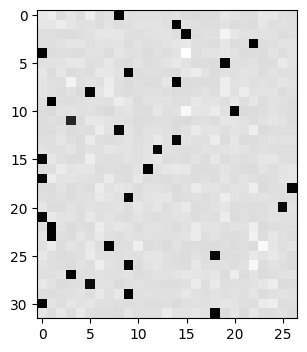

In [8]:
# Exercise 2: backprop through cross_entropy

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), "diff:", (loss_fast - loss).item())

# backward pass
dlogits = F.softmax(logits, dim=1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp(
    "logits", dlogits, logits
)  # I can only get approximate to be true, my maxdiff is 6e-9

# dlogits.sum(1) ~0
plt.figure(figsize=(4, 4))
plt.imshow(dlogits.detach(), cmap="gray")

In [9]:
# Exercise 3: backprop through batchnorm

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = (
    bngain
    * (hprebn - hprebn.mean(0, keepdim=True))
    / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5)
    + bnbias
)
print("max diff:", (hpreact_fast - hpreact).abs().max())

# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

dhprebn = (
    bngain
    * bnvar_inv
    / n
    * (n * dhpreact - dhpreact.sum(0) - n / (n - 1) * bnraw * (dhpreact * bnraw).sum(0))
)

cmp(
    "hprebn", dhprebn, hprebn
)  # I can only get approximate to be true, my maxdiff is 9e-10

max diff: tensor(7.1526e-07, grad_fn=<MaxBackward1>)
hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


## Final Gradients By Hand 

In [10]:
# manual backprop! #swole_doge_meme
def calc_grads(
    Xb,
    Yb,
    C,
    W1,
    bngain,
    bnvar_inv,
    embcat,
    h,
    bnraw,
    logits,
):
    dlogits = (F.softmax(logits, dim=1) - F.one_hot(Yb, logits.shape[1])) / n
    # parameters: Linear layer #2
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1.0 - h**2) * (dlogits @ W2.T)
    # parameters: BatchNorm layer
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    # batchnorm
    dhprebn = (
        bngain
        * bnvar_inv
        * (
            dhpreact
            - dhpreact.mean(0)
            - 1 / (n - 1) * bnraw * (dhpreact * bnraw).sum(0)
        )
    )
    # parameters: Linear layer #1
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # parameters: Embedding layer
    dC = torch.zeros_like(C)
    dC.index_add_(0, Xb.view(-1), (dhprebn @ W1.T).view(-1, C.shape[1]))

    return [dC, dW1, db1, dW2, db2, dbngain, dbnbias]

#### Similar Optimization as Part 3

In [11]:
# init
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
# Layer 1
W1 = (
    torch.randn((n_embd * block_size, n_hidden), generator=g)
    * (5 / 3)
    / ((n_embd * block_size) ** 0.5)
)
b1 = torch.randn(n_hidden, generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

# same optimization as part 2
max_steps = 200000
batch_size = 32
n = batch_size  # convenience
lossi = []


def train(torch_no_grad=True, early_stop=None):
    for i in range(max_steps):

        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

        # forward pass
        emb = C[Xb]  # embed the characters into vectors
        embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
        # Linear layer
        hprebn = embcat @ W1 + b1  # hidden layer pre-activation
        # BatchNorm layer
        # -------------------------------------------------------------
        bnmean = hprebn.mean(0, keepdim=True)
        bnvar = hprebn.var(0, keepdim=True, unbiased=True)
        bnvar_inv = (bnvar + 1e-5) ** -0.5
        bnraw = (hprebn - bnmean) * bnvar_inv
        hpreact = bngain * bnraw + bnbias
        # -------------------------------------------------------------
        # Non-linearity
        h = torch.tanh(hpreact)  # hidden layer
        logits = h @ W2 + b2  # output layer
        loss = F.cross_entropy(logits, Yb)  # loss function

        # PyTorch backward pass: use this for correctness comparisons
        if not torch_no_grad:
            for p in parameters:
                p.grad = None
            loss.backward()

        # manual backward pass
        grads = calc_grads(
            Xb=Xb,
            Yb=Yb,
            C=C,
            W1=W1,
            bngain=bngain,
            bnvar_inv=bnvar_inv,
            embcat=embcat,
            h=h,
            bnraw=bnraw,
            logits=logits,
        )

        # update
        lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
        for p, grad in zip(parameters, grads):
            # p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
            p.data += -lr * grad  # new way of swole doge TODO: enable

        # track stats
        if i % 10000 == 0:  # print every once in a while
            print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
        lossi.append(loss.log10().item())

        if early_stop and i >= early_stop:
            break
    return parameters, grads


# Validate manual gradients with PyTorch
# parameters, grads = train(torch_no_grad=False, early_stop=100)
# for p,g in zip(parameters, grads):
#     cmp(str(tuple(p.shape)), g, p)

# Train with manual gradients: IMPL with context manager for efficiency
with torch.no_grad():
    parameters, grads = train(torch_no_grad=True)

12297
      0/ 200000: 3.7788


  10000/ 200000: 2.1750
  20000/ 200000: 2.3473
  30000/ 200000: 2.4451
  40000/ 200000: 1.9822
  50000/ 200000: 2.3631
  60000/ 200000: 2.3218
  70000/ 200000: 2.0068
  80000/ 200000: 2.3553
  90000/ 200000: 2.1543
 100000/ 200000: 1.9232
 110000/ 200000: 2.3222
 120000/ 200000: 2.0078
 130000/ 200000: 2.4309
 140000/ 200000: 2.2687
 150000/ 200000: 2.1720
 160000/ 200000: 1.9083
 170000/ 200000: 1.8097
 180000/ 200000: 1.9952
 190000/ 200000: 1.8923


In [12]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [13]:
# evaluate train and val loss


@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    emb = C[x]  # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5) ** -0.5 + bnbias
    h = torch.tanh(hpreact)  # (N, n_hidden)
    logits = h @ W2 + b2  # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 2.0705418586730957
val 2.109055757522583


In [14]:
# I achieved:
# train 2.0718822479248047
# val 2.1162495613098145

In [15]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        # ------------
        # forward pass:
        # Embedding
        emb = C[torch.tensor([context])]  # (1,block_size,d)
        embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
        hpreact = embcat @ W1 + b1
        hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5) ** -0.5 + bnbias
        h = torch.tanh(hpreact)  # (N, n_hidden)
        logits = h @ W2 + b2  # (N, vocab_size)
        # ------------
        # Sample
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print("".join(itos[i] for i in out))

mora.
mayah.
see.
mad.
ryla.
ren.
ruthadrie.
cadelynnelin.
shi.
jenleigh.
sana.
arleigh.
malaia.
noshubergihiriel.
kindreelynn.
novana.
uba.
geder.
yarul.
els.
